# COVID-19 

In this notebook we will go through the developments around the COVID-19 virus infections. First we look at the developments worldwide and finally EU only.

The dataset which I use in this project is provided by the [`European Centre for Disease Prevention and Control (ECDC)`](https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases)

* Author: Erfan Nariman
* Date: 10-03-2020
* GitHub: [erfannariman](github.com/ErfPy)

---

In [2]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.max_columns', None)

---

### data import

In [4]:
df = pd.read_excel(os.path.join('..', 'data', 'COVID-19-geographic-disbtribution-worldwide-2020-03-18.xls'))

df.shape

(5529, 8)

In [10]:
df.head()

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,2020-03-18,18,3,2020,1,0,Afghanistan,AF
1,2020-03-17,17,3,2020,5,0,Afghanistan,AF
2,2020-03-16,16,3,2020,6,0,Afghanistan,AF
3,2020-03-15,15,3,2020,3,0,Afghanistan,AF
4,2020-03-11,11,3,2020,3,0,Afghanistan,AF


---

# Worldwide
Minus China, to get rid of the extreme values for our model later on

### data cleaning

In [11]:
# clean up column names
df.columns = df.columns.str.replace('DateRep', 'Date').str.replace('Countries and territories', 'Country')

# convert Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# we filter out China to get rid of the extreme values
china = df.query('Country.eq("China")').copy()
df = df.query('Country.ne("China")').copy()

# replace name to Japan
df['Country'] = df['Country'].str.replace('Cases on an international conveyance Japan', 'Japan')

# print first 5 rows of dataframe
df.head()

,Date,Day,Month,Year,Cases,Deaths,Country,GeoId
0,2020-03-18,18,3,2020,1,0,Afghanistan,AF
1,2020-03-17,17,3,2020,5,0,Afghanistan,AF
2,2020-03-16,16,3,2020,6,0,Afghanistan,AF
3,2020-03-15,15,3,2020,3,0,Afghanistan,AF
4,2020-03-11,11,3,2020,3,0,Afghanistan,AF


### exploratory data analysis (EDA)

In [12]:
# range of data in days
df['Date'].max() - df['Date'].min()

Timedelta('78 days 00:00:00')

In [13]:
# checking for missing days by resampling and checking for NaN
df.set_index('Date').resample('D').mean().isna().sum()

Day       0
Month     0
Year      0
Cases     0
Deaths    0
dtype: int64

### which countries had highest new confirmed cases on a day

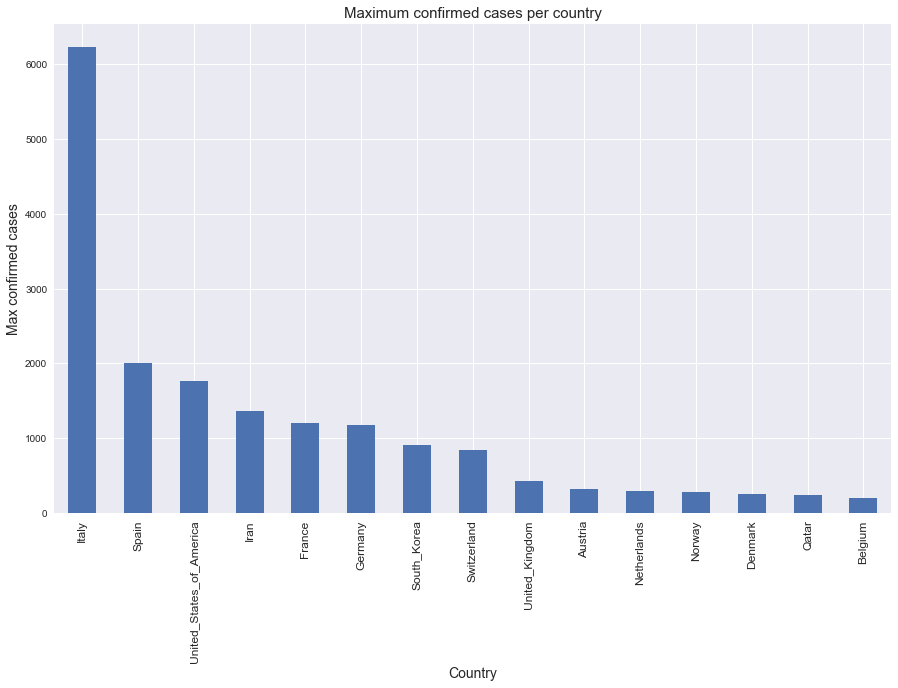

In [14]:
df.groupby('Country')['Cases'].max().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Max confirmed cases', size=14)
plt.xlabel('Country', size=14)
plt.title('Maximum confirmed cases per country', size=15)
plt.savefig('../plots/plt1.png', dpi=100)
plt.show()

### countries with highest total confirmed cases

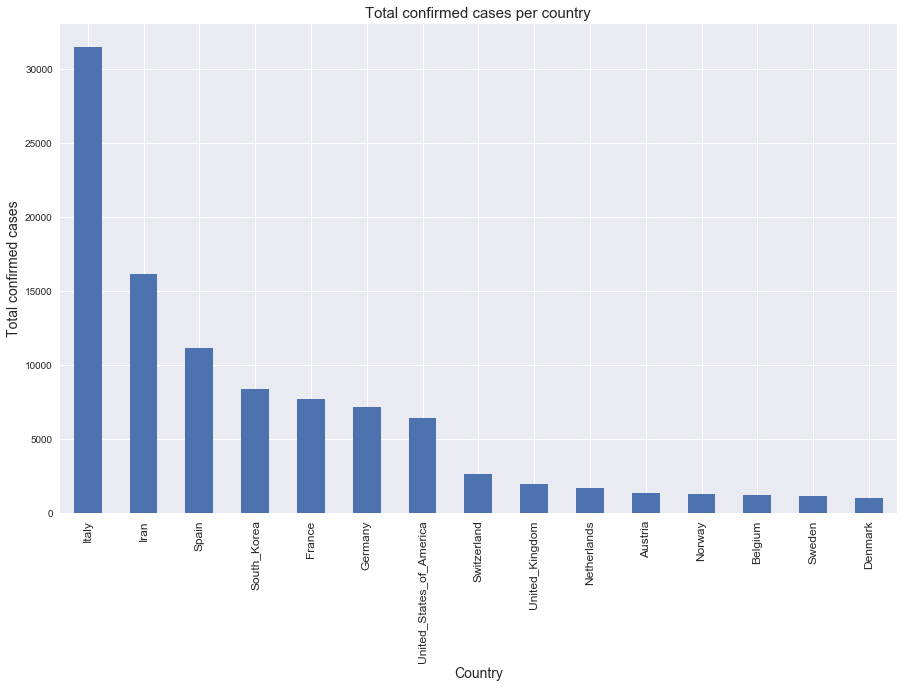

In [15]:
df.groupby('Country')['Cases'].sum().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Total confirmed cases', size=14)
plt.xlabel('Country', size=14)
plt.title('Total confirmed cases per country', size=15)
plt.savefig('../plots/plt2.png', dpi=100)
plt.show()

### cumulative sum of confirmed cases over time

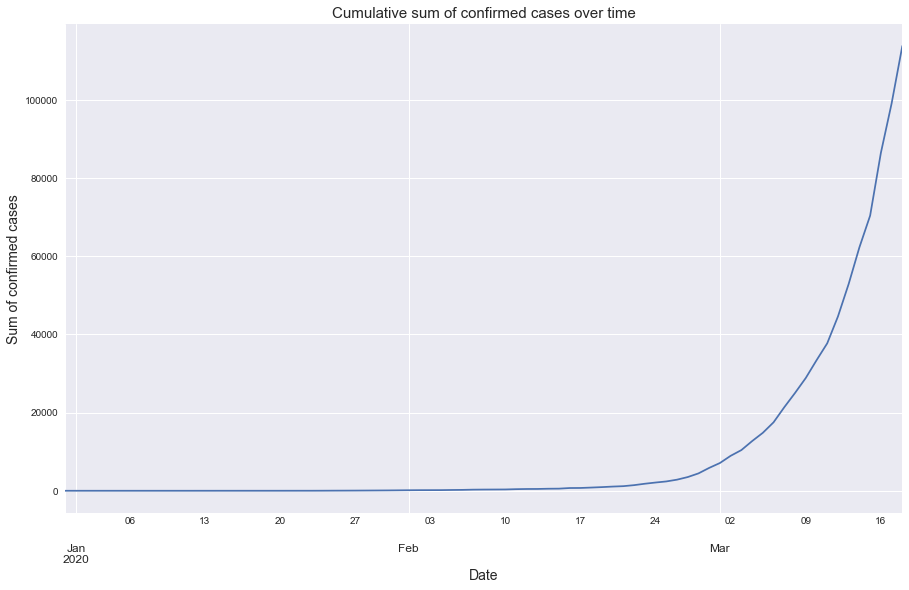

In [36]:
cases_cumsum = df.groupby('Date')['Cases'].sum().cumsum()
cases_cumsum.plot(figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Sum of confirmed cases', size=14)
plt.xlabel('Date', size=14)
plt.title('Cumulative sum of confirmed cases over time', size=15)
plt.savefig('../plots/plt3.png')
plt.show()

### The log of cumulative sum to check if growth is actually exponential

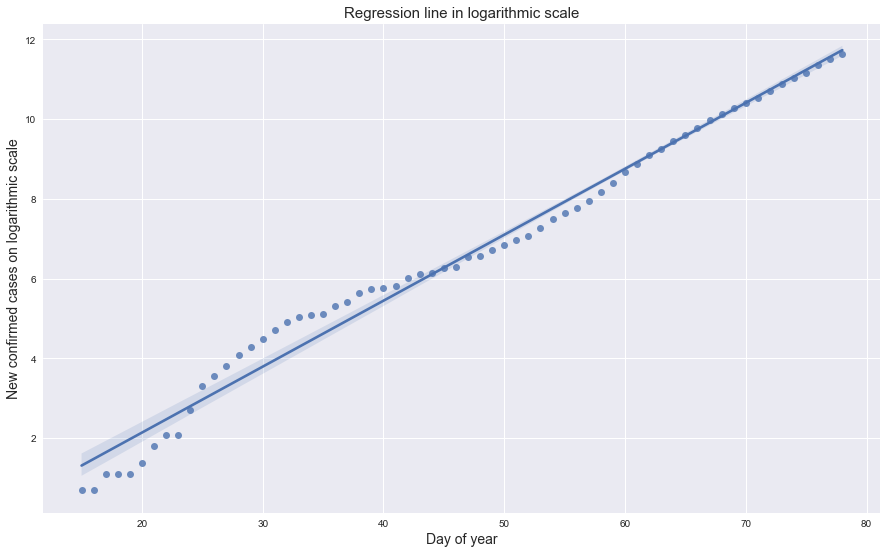

In [38]:
log_cumsum = np.log(cases_cumsum[cases_cumsum.gt(1)]).to_frame().reset_index()
log_cumsum['Date'] = log_cumsum['Date'].dt.dayofyear

plt.figure(figsize=(15,9))
plt.title("Regression line in logarithmic scale", size=15)
sns.regplot(x='Date', y='Cases', data=log_cumsum)
plt.xlabel('Day of year', size=14)
plt.ylabel('New confirmed cases on logarithmic scale', size=14)
plt.savefig('../plots/plt4.png')
plt.show()

### fit a regression line through the log of confirmed cases, this way we can check R^2 

In [40]:
X = log_cumsum['Date']
y = log_cumsum['Cases']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Cases   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              9362.
Date:                Thu, 19 Mar 2020   Prob (F-statistic):                    3.10e-70
Time:                        01:28:33   Log-Likelihood:                         -57.010
No. Observations:                  64   AIC:                                      116.0
Df Residuals:                      63   BIC:                                      118.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Date           0.1437      0.001     96.758      0.000       0.141       0.147
==============================================================================
Omnibus:                       16.847   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.903
Skew:                          -1.312   Prob(JB):                     4.77e-05
Kurtosis:                       3.758   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### growth proportion per day, > 1 means we are still in an exponential growth

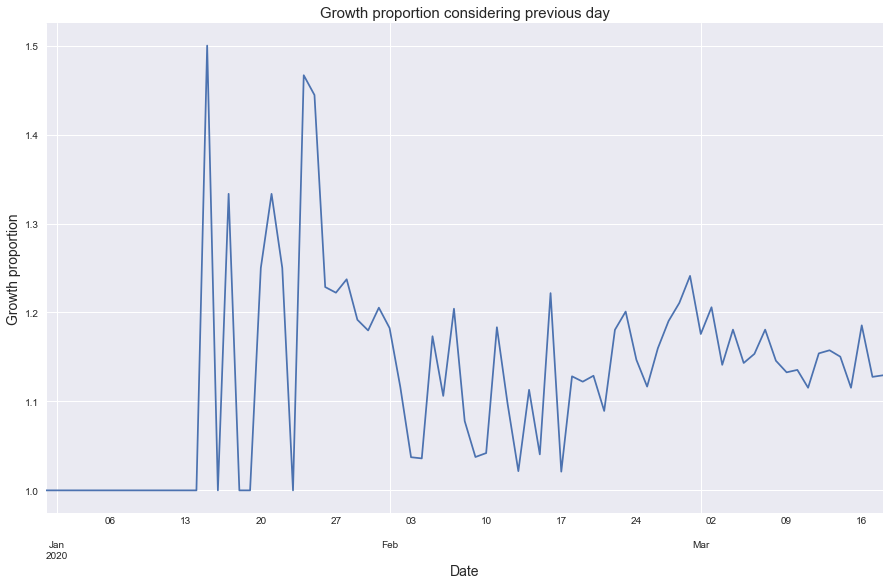

In [41]:
cases_cumsum = cases_cumsum.replace(0, 1)
cases_cumsum.diff().div(cases_cumsum).add(1).fillna(1).plot(figsize=(15,9))

plt.title('Growth proportion considering previous day', size=15)
plt.xlabel('Date', size=14)
plt.ylabel('Growth proportion', size=14)
plt.savefig('../plots/plt5.png')
plt.show()

### time series analysis

In [42]:
from itertools import product

p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

In [43]:
y = cases_cumsum
y.index = pd.DatetimeIndex(y.index.values,
                           freq=y.index.inferred_freq)

results_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            results_list.append((param, param_seasonal, results.aic))
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1803.9717148710083
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1528.4343343576936
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1518.5175886423833
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1251.9015718912742
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1259.178326782645
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1215.702940987331
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1063.6210277066073
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1040.283680555527
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1725.5835902345045
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1482.1959130210428
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1450.5592947833495
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1184.1030713126527
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1183.8707425194987


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1155.7620977932163
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1003.6014752626577
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:964.4118133910067
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1482.7692342766795
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1236.5656646190598
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1239.85412623018
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1006.5856034040384
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1055.7954934047116
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1042.768896339319
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:876.7771867665862
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:863.294900425245
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1410.271236446441
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1200.4523122155424
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1198.0290084066885
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:953.5226529761019
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1047.8961630042058


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1020.3737926117321
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:872.1920099184051


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:845.1926038201618
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1240.8235789294379
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1060.376850366846
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1051.8751720867583
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:869.9719571737093
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1043.328206802325
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1044.9004126621323
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:861.5231114111646
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:863.3154854396814
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1208.579827689125


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1043.4841627076726
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1028.5169532063867
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:851.8643658265421


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1045.2329839150593


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1032.8954106584506
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:863.4170948310702
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:850.8176479810463
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1297.1553741860357


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1109.4469295917559
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1093.6152674385653
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:916.3859590302022
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1034.5064303837528
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1035.9466668998418
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:854.6552628792004
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:856.3296746460597


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1216.1892141744656
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1050.4083556195928
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1026.4078389033446


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:858.0921597905473
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1033.3109723427328
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1021.0940686260244
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:851.2517364031141
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:840.8193519047236


In [44]:
min_aic = min([aic for x, y, aic in results_list if aic > 0])
for param, p_seasonal, aic in results_list:
    if aic == min_aic:
        p, p_s, a = param, p_seasonal, aic

print(p, p_s, a)

(1, 1, 1) (1, 1, 1, 12) 840.8193519047236


In [45]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=p,
                                seasonal_order=p_s,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8471      0.093      9.076      0.000       0.664       1.030
ma.L1         -0.5471      0.131     -4.185      0.000      -0.803      -0.291
ar.S.L12       5.1959      0.365     14.221      0.000       4.480       5.912
ma.S.L12      -0.0948      0.358     -0.264      0.791      -0.797       0.608
sigma2      4.885e+05   6.52e+04      7.496      0.000    3.61e+05    6.16e+05


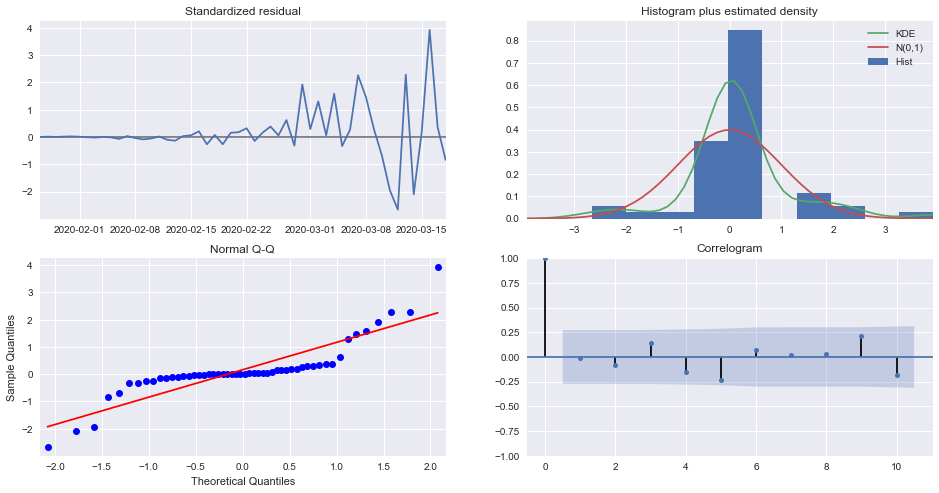

In [46]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('../plots/plt6.png')
plt.show()

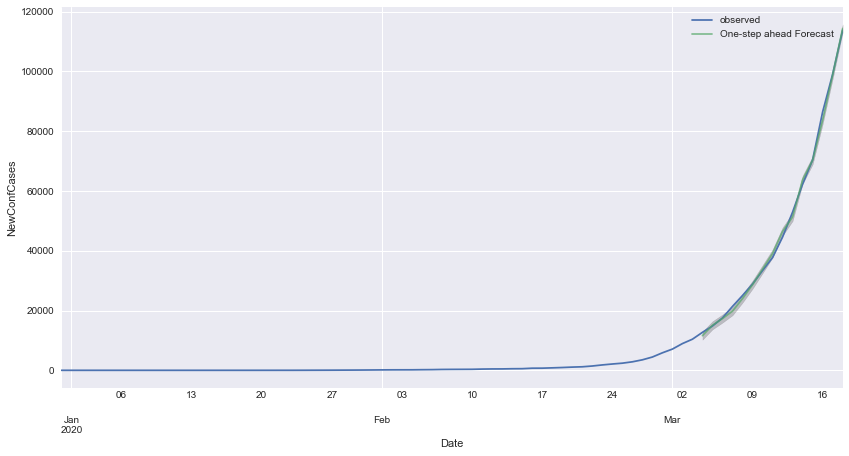

In [47]:
pred = results.get_prediction(start=(y.index.max() - pd.Timedelta(days=14)), dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('NewConfCases')
plt.legend()
plt.savefig('../plots/plt7.png')
plt.show()

In [48]:
y_forecasted = pred.predicted_mean
y_truth = y[(y.index.max() - pd.Timedelta(days=14)):]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {round(mse, 2)}')

The Mean Squared Error of our forecasts is 1543018.85


In [49]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}')

The Root Mean Squared Error of our forecasts is 1242.18


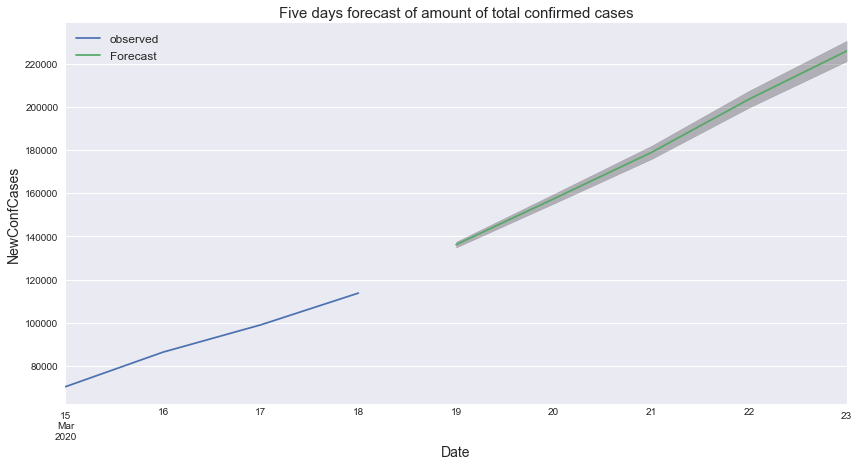

In [50]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y[(y.index.max() - pd.Timedelta(days=3)):].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('NewConfCases', size=14)
plt.legend(fontsize=12)
plt.title('Five days forecast of amount of total confirmed cases', size=15)
plt.savefig('../plots/plt8.png')
plt.show()

# Netherlands

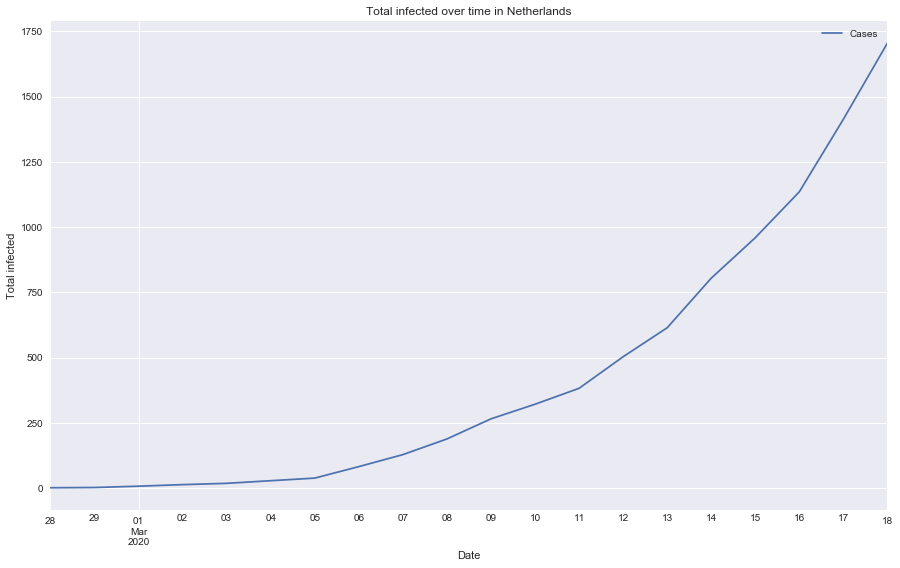

In [52]:
df.query('Country == "Netherlands" & Cases > 0').loc[:, ['Date', 'Cases']].set_index('Date').sort_index().cumsum().plot(figsize=(15,9))
plt.ylabel('Total infected')
plt.title('Total infected over time in Netherlands')
plt.savefig('../plots/NL1.png')
plt.show()

In [54]:
df.query('Country == "Netherlands" & Cases > 0')

,Date,Day,Month,Year,Cases,Deaths,Country,GeoId
3519,2020-03-18,18,3,2020,292,0,Netherlands,NL
3520,2020-03-17,17,3,2020,278,4,Netherlands,NL
3521,2020-03-16,16,3,2020,176,8,Netherlands,NL
3522,2020-03-15,15,3,2020,155,7,Netherlands,NL
3523,2020-03-14,14,3,2020,190,0,Netherlands,NL
3524,2020-03-13,13,3,2020,111,0,Netherlands,NL
3525,2020-03-12,12,3,2020,121,1,Netherlands,NL
3526,2020-03-11,11,3,2020,61,1,Netherlands,NL
3527,2020-03-10,10,3,2020,56,0,Netherlands,NL
3528,2020-03-09,9,3,2020,77,2,Netherlands,NL


### Amount of confirmed cases per city

In [25]:
per_city = pd.read_csv(os.path.join('..', 'data', 'besmettingen_per_buurt.csv'), sep=';')
per_city['Aantal per 100.000 inwoners'] = per_city['Aantal per 100.000 inwoners'].str.replace(',', '.').astype(float)
per_city.head()

,Category,Aantal per 100.000 inwoners,Aantal
0,'s-Gravenhage,5.0,27
1,'s-Hertogenbosch,22.7,35
2,Aa en Hunze,0.0,0
3,Aalsmeer,12.6,4
4,Aalten,0.0,0


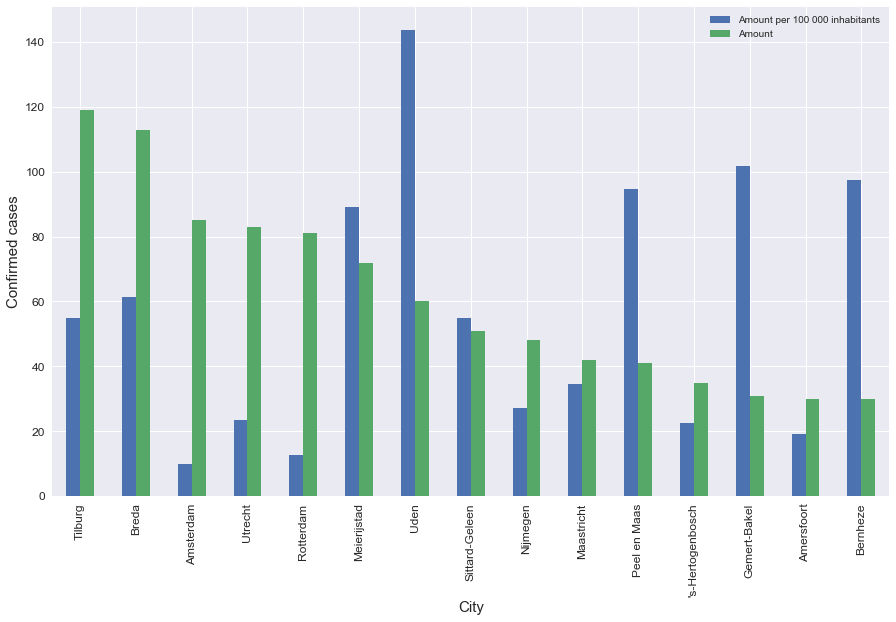

In [37]:
per_city.sort_values('Aantal', ascending=False).head(15).plot(kind='bar', figsize=(15,9), x='Category')
plt.xlabel('City', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Confirmed cases', size=15)
plt.legend(['Amount per 100 000 inhabitants', 'Amount'])
plt.savefig('../plots/NL2.png')
plt.show()

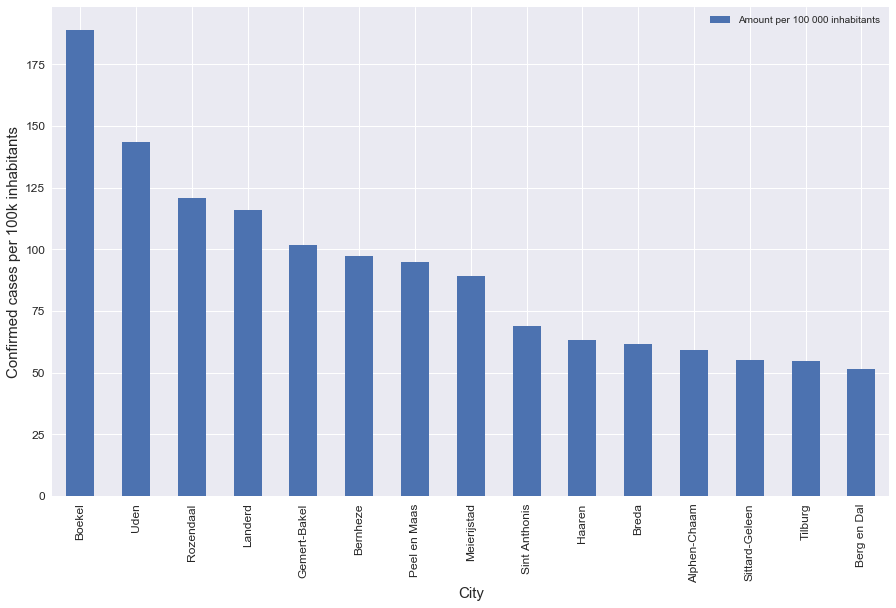

In [38]:
per_city.sort_values('Aantal per 100.000 inwoners', ascending=False).head(15).plot(kind='bar', figsize=(15,9), x='Category', y='Aantal per 100.000 inwoners')
plt.xlabel('City', size=15)
plt.xticks(size=12)
plt.ylabel('Confirmed cases per 100k inhabitants', size=15)
plt.yticks(size=12)
plt.legend(['Amount per 100 000 inhabitants', 'Amount'])
plt.savefig('../plots/NL3.png')
plt.show()

# China

In [55]:
china = china.set_index('Date').sort_index()
china.sort_index(ascending=False)

,Day,Month,Year,Cases,Deaths,Country,GeoId
Date,,,,,,,
2020-03-18,18,3,2020,33,16,China,CN
2020-03-17,17,3,2020,110,9,China,CN
2020-03-16,16,3,2020,25,14,China,CN
2020-03-15,15,3,2020,22,9,China,CN
2020-03-14,14,3,2020,19,15,China,CN
...,...,...,...,...,...,...,...
2020-01-04,4,1,2020,0,0,China,CN
2020-01-03,3,1,2020,17,0,China,CN
2020-01-02,2,1,2020,0,0,China,CN


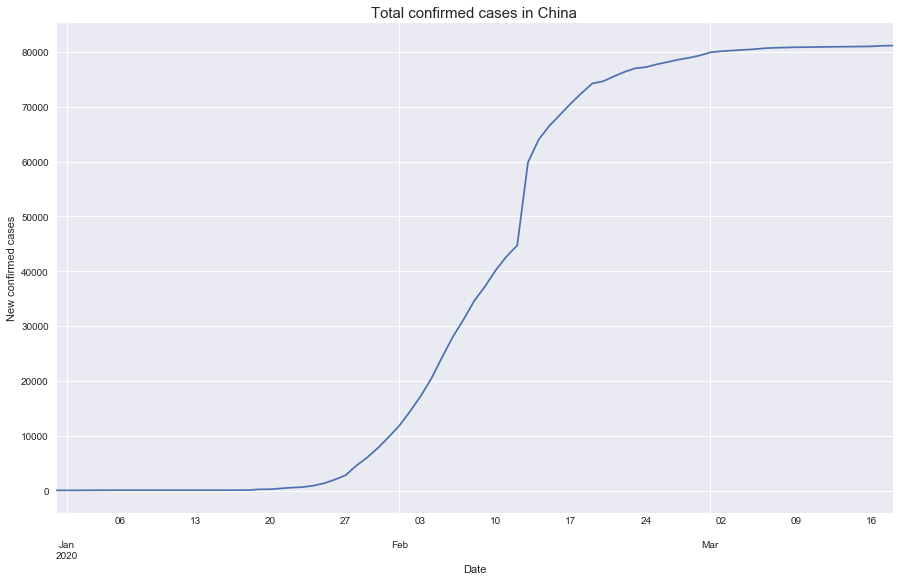

In [57]:
china['Cases'].cumsum().plot(figsize=(15,9))
plt.ylabel('New confirmed cases')
plt.title('Total confirmed cases in China', size=15)
plt.savefig('../plots/china1.png')
plt.show()

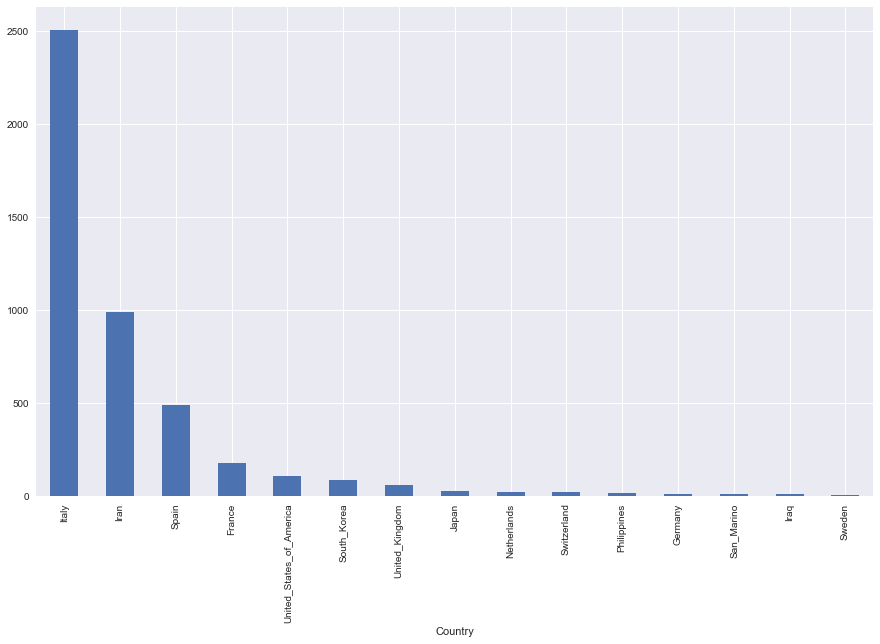

In [59]:
df.groupby('Country')['Deaths'].sum().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))

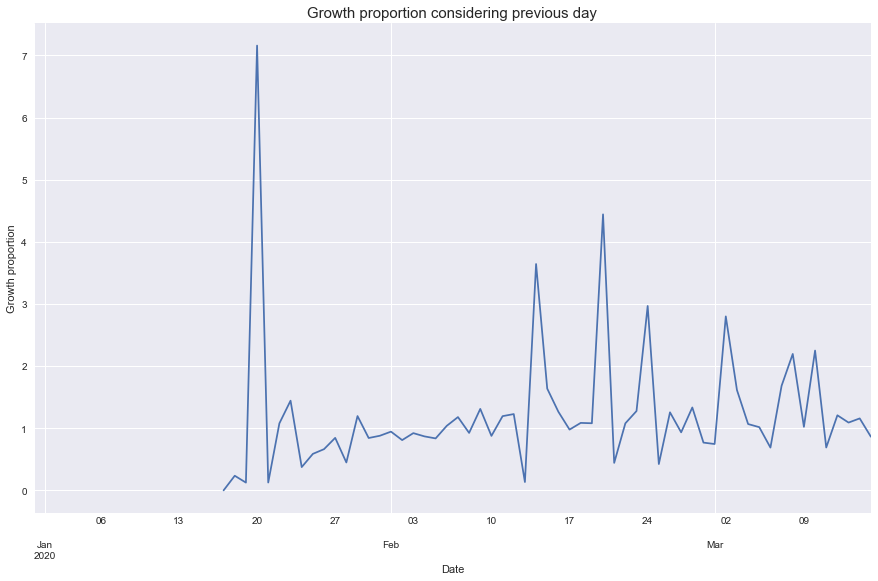

In [63]:
china['NewConfCases'].shift().div(china['NewConfCases']).plot(figsize=(15,9))
plt.ylabel('Growth proportion')
plt.title('Growth proportion considering previous day', size=15)
plt.savefig('../plots/china1.png')
plt.show()

---